In [24]:
import sys
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F

PROJECT_ROOT = Path.cwd().parents[1]
sys.path.append(str(PROJECT_ROOT))
print("PROJECT_ROOT =", PROJECT_ROOT)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

redim_model = torch.hub.load(
    "IDRnD/ReDimNet",
    "ReDimNet",
    model_name="b5",
    train_type="ptn",
    dataset="vox2",
).to(DEVICE).eval()

print("Loaded ReDimNet successfully.")


PROJECT_ROOT = /home/SpeakerRec/BioVoice
Using device: cuda


Using cache found in /home/SpeakerRec/.cache/torch/hub/IDRnD_ReDimNet_master


Loaded ReDimNet successfully.


In [25]:
for p in redim_model.parameters():
    p.requires_grad = False

redim_model.eval()


ReDimNetWrap(
  (backbone): ReDimNet(
    (stem): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): LayerNorm(C=(32,), data_format=channels_first, eps=1e-06)
      (2): to1d()
    )
    (stage0): Sequential(
      (0): weigth1d(w=(1, 1, 1, 1),sequential=False)
      (1): to2d(f=72,c=32)
      (2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (3): ConvBlock2d(
        (conv_block): ResBasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
          (conv1pw): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
          (conv2pw): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [26]:
wav_dir = PROJECT_ROOT / "data" / "wavs"

SPEAKERS = ["eden", "idan", "yoav"]
speaker_to_id = {s: i for i, s in enumerate(SPEAKERS)}
id_to_speaker = {i: s for s, i in speaker_to_id.items()}

def speaker_from_name(p: Path) -> str | None:
    name = p.stem.lower()
    for s in SPEAKERS:
        if name.startswith(s + "_"):
            return s
    return None

all_items = []
for p in sorted(wav_dir.glob("*.wav")):
    s = speaker_from_name(p)
    if s is None:
        continue
    all_items.append((p, speaker_to_id[s], s))

print("Total wavs:", len(all_items))
for s in SPEAKERS:
    print(s, "=", sum(1 for _, _, sp in all_items if sp == s))


Total wavs: 90
eden = 30
idan = 30
yoav = 30


In [27]:
TARGET_SR = 16000

@torch.no_grad()
def embed_with_redim_torch(wav_path: str, l2_norm: bool = True) -> torch.Tensor:
    wav, sr = torchaudio.load(wav_path)

    if sr != TARGET_SR:
        wav = torchaudio.functional.resample(wav, sr, TARGET_SR)

    wav = wav[:1, :].float().to(DEVICE)  # [1, T]
    emb = redim_model(wav)               # [1, 192]
    emb = emb.squeeze(0)                 # [192]

    if l2_norm:
        emb = emb / (emb.norm(p=2) + 1e-12)

    return emb.detach().cpu()


In [28]:
def set_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(1234)

X = []
y = []
paths = []
speakers = []

for p, label, spk in all_items:
    emb = embed_with_redim_torch(str(p), l2_norm=True)  # [192] on CPU
    X.append(emb)
    y.append(label)
    paths.append(p)
    speakers.append(spk)

X = torch.stack(X, dim=0)          # [N, 192]
y = torch.tensor(y, dtype=torch.long)  # [N]

print("X:", X.shape, "y:", y.shape)

# optional: save to disk so you never re-embed unless you change data
cache_path = PROJECT_ROOT / "data" / "redim_team_embeddings.pt"
torch.save({"X": X, "y": y, "paths": paths, "speakers": speakers}, cache_path)
print("Saved cache to:", cache_path)


X: torch.Size([90, 192]) y: torch.Size([90])
Saved cache to: /home/SpeakerRec/BioVoice/data/redim_team_embeddings.pt


In [29]:
def split_indices_by_speaker(paths, speakers, val_ratio=0.2, seed=1234):
    rng = random.Random(seed)
    idx_by_spk = {s: [] for s in SPEAKERS}
    for i, spk in enumerate(speakers):
        idx_by_spk[spk].append(i)

    train_idx, val_idx = [], []
    for spk, idxs in idx_by_spk.items():
        rng.shuffle(idxs)
        n_val = max(1, int(len(idxs) * val_ratio))
        val_idx.extend(idxs[:n_val])
        train_idx.extend(idxs[n_val:])

    rng.shuffle(train_idx)
    rng.shuffle(val_idx)
    return train_idx, val_idx

train_idx, val_idx = split_indices_by_speaker(paths, speakers, val_ratio=0.2, seed=1234)
print("train:", len(train_idx), "val:", len(val_idx))


train: 72 val: 18


In [30]:

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val     = X[val_idx], y[val_idx]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=128, shuffle=False)


In [31]:
class SpeakerHead(nn.Module):
    def __init__(self, in_dim=192, num_classes=3):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

head = SpeakerHead(in_dim=X.shape[1], num_classes=len(SPEAKERS)).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(head.parameters(), lr=1e-3, weight_decay=1e-4)

def eval_loss_and_acc(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            logits = model(xb)
            loss = criterion(logits, yb)

            total_loss += loss.item() * yb.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.numel()

    avg_loss = total_loss / max(1, total)
    acc = correct / max(1, total)
    return avg_loss, acc


train_loss_hist = []
val_loss_hist = []
train_acc_hist = []
val_acc_hist = []

best_val = -1.0
best_state = None

EPOCHS = 60
for epoch in range(1, EPOCHS + 1):
    head.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        optimizer.zero_grad()
        logits = head(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * yb.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    val_loss, val_acc = eval_loss_and_acc(head, val_loader, criterion)
    _, train_acc = eval_loss_and_acc(head, train_loader, criterion)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    if val_acc > best_val:
        best_val = val_acc
        best_state = {k: v.detach().cpu().clone() for k, v in head.state_dict().items()}

    if epoch % 5 == 0 or epoch == 1:
        print(
            f"epoch {epoch:3d} | "
            f"train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | "
            f"train_acc {train_acc:.3f} | val_acc {val_acc:.3f} | best {best_val:.3f}"
        )

head.load_state_dict(best_state)
head.eval()
print("Best val acc:", best_val)

epoch   1 | train_loss 1.1063 | val_loss 1.0885 | train_acc 0.333 | val_acc 0.333 | best 0.333
epoch   5 | train_loss 1.0566 | val_loss 1.0415 | train_acc 0.458 | val_acc 0.556 | best 0.556
epoch  10 | train_loss 0.9987 | val_loss 0.9864 | train_acc 0.944 | val_acc 1.000 | best 1.000
epoch  15 | train_loss 0.9435 | val_loss 0.9334 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  20 | train_loss 0.8914 | val_loss 0.8832 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  25 | train_loss 0.8423 | val_loss 0.8361 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  30 | train_loss 0.7959 | val_loss 0.7918 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  35 | train_loss 0.7522 | val_loss 0.7501 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  40 | train_loss 0.7112 | val_loss 0.7110 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  45 | train_loss 0.6726 | val_loss 0.6742 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  50 | train_loss 0.6366 | val_loss 0.6396 | 

In [ ]:
head_path = PROJECT_ROOT / "data" / "redim_speaker_head.pt"
torch.save(
    {
        "state_dict": head.state_dict(),
        "speaker_to_id": speaker_to_id,
        "speakers": SPEAKERS,
        "l2_norm_emb": True, 
    },
    head_path,
)
print("Saved head to:", head_path)


Saved head to: /home/SpeakerRec/BioVoice/data/redim_speaker_head.pt


In [33]:
import pandas as pd

@torch.no_grad()
def score_wav(path: Path):
    emb = embed_with_redim_torch(str(path), l2_norm=True).to(DEVICE)  # [192]
    logits = head(emb.unsqueeze(0)).squeeze(0)                        # [3]
    probs = F.softmax(logits, dim=0).detach().cpu().numpy()

    pred_id = int(np.argmax(probs))
    pred_spk = id_to_speaker[pred_id]

    # second best prob
    sorted_probs = np.sort(probs)[::-1]
    best_p = float(sorted_probs[0])
    second_p = float(sorted_probs[1])

    return probs, pred_spk, best_p, second_p

rows = []
for (p, true_id, true_spk) in all_items:
    probs, pred_spk, best_p, second_p = score_wav(p)
    p_true = float(probs[true_id])
    margin = p_true - second_p  # strong confidence when large

    rows.append({
        "path": str(p),
        "file": p.name,
        "true": true_spk,
        "pred": pred_spk,
        "p_true": p_true,
        "margin": margin,
        "p_eden": float(probs[speaker_to_id["eden"]]),
        "p_idan": float(probs[speaker_to_id["idan"]]),
        "p_yoav": float(probs[speaker_to_id["yoav"]]),
    })

df = pd.DataFrame(rows)
df["correct"] = df["true"] == df["pred"]

print("overall accuracy on all wavs (not just val):", df["correct"].mean())

# Top-N representatives per speaker
TOP_N = 3
for spk in SPEAKERS:
    top = df[df["true"] == spk].sort_values(["margin", "p_true"], ascending=False).head(TOP_N)
    print("\n==== TOP", TOP_N, "for", spk, "====")
    display(top[["file", "true", "pred", "p_true", "margin", "p_eden", "p_idan", "p_yoav"]])


overall accuracy on all wavs (not just val): 0.9555555555555556

==== TOP 3 for eden ====


,file,true,pred,p_true,margin,p_eden,p_idan,p_yoav
16,eden_017.wav,eden,eden,0.371280,0.041723,0.371280,0.329557,0.299164
20,eden_021.wav,eden,eden,0.362884,0.040386,0.362884,0.322497,0.314619
11,eden_012.wav,eden,eden,0.367772,0.035704,0.367772,0.332068,0.300161



==== TOP 3 for idan ====


,file,true,pred,p_true,margin,p_eden,p_idan,p_yoav
38,idan_009.wav,idan,idan,0.425183,0.135628,0.289555,0.425183,0.285263
33,idan_004.wav,idan,idan,0.422946,0.131526,0.291420,0.422946,0.285634
41,idan_012.wav,idan,idan,0.418769,0.124931,0.293838,0.418769,0.287393



==== TOP 3 for yoav ====


,file,true,pred,p_true,margin,p_eden,p_idan,p_yoav
87,yoav_028.wav,yoav,yoav,0.369886,0.046129,0.323756,0.306358,0.369886
83,yoav_024.wav,yoav,yoav,0.364003,0.045203,0.318800,0.317197,0.364003
81,yoav_022.wav,yoav,yoav,0.364693,0.041620,0.323074,0.312233,0.364693


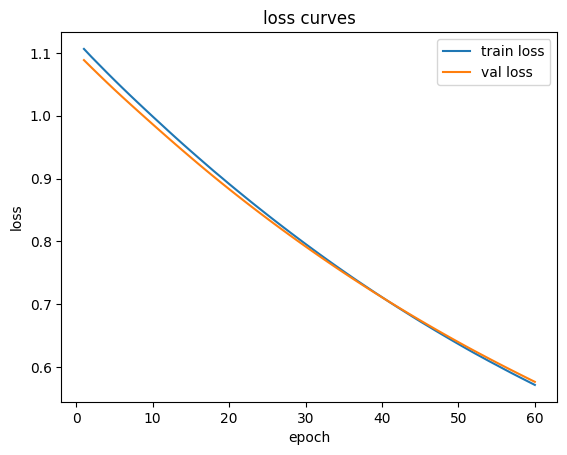

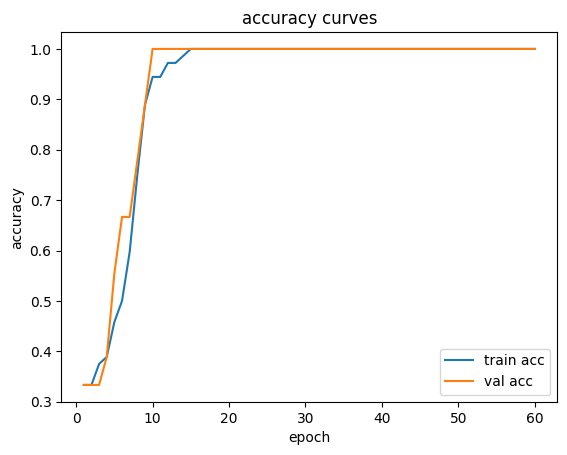

In [34]:
epochs = np.arange(1, len(train_loss_hist) + 1)

plt.figure()
plt.plot(epochs, train_loss_hist, label="train loss")
plt.plot(epochs, val_loss_hist, label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("loss curves")
plt.show()

plt.figure()
plt.plot(epochs, train_acc_hist, label="train acc")
plt.plot(epochs, val_acc_hist, label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title("accuracy curves")
plt.show()


In [35]:
cm = pd.crosstab(df["true"], df["pred"], rownames=["true"], colnames=["pred"])
display(cm)

per_class_acc = (df["true"] == df["pred"]).groupby(df["true"]).mean()
display(per_class_acc)

pred,eden,idan,yoav
true,,,
eden,27,3,0
idan,0,30,0
yoav,1,0,29


true
eden    0.900000
idan    1.000000
yoav    0.966667
dtype: float64

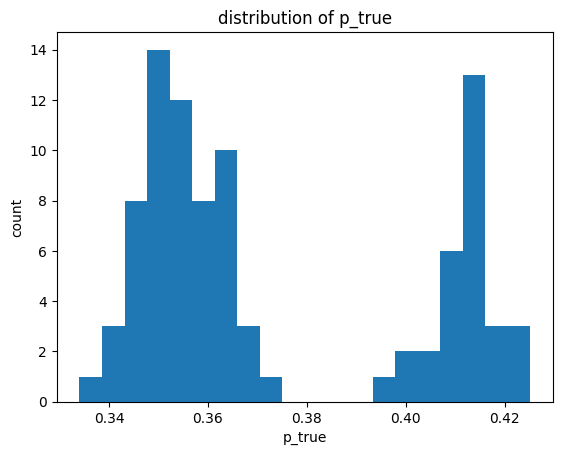

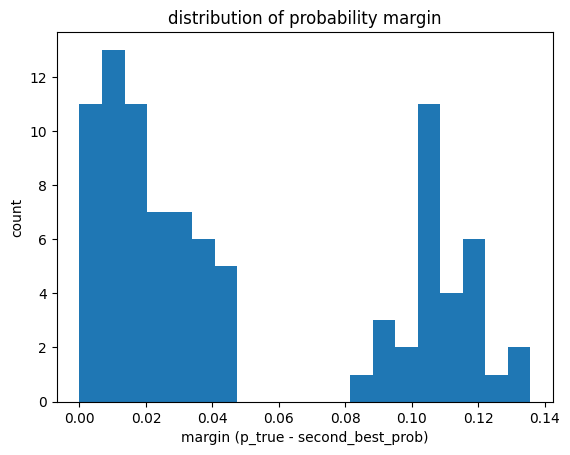

In [36]:
plt.figure()
plt.hist(df["p_true"].values, bins=20)
plt.xlabel("p_true")
plt.ylabel("count")
plt.title("distribution of p_true")
plt.show()

plt.figure()
plt.hist(df["margin"].values, bins=20)
plt.xlabel("margin (p_true - second_best_prob)")
plt.ylabel("count")
plt.title("distribution of probability margin")
plt.show()
